In [1]:
from braindecode.preprocessing import (
    exponential_moving_standardize,
    preprocess,
    Preprocessor)
from numpy import multiply
from braindecode.datasets import MOABBDataset
from braindecode.preprocessing import create_windows_from_events
import torch
from braindecode.util import set_random_seeds

from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split
from braindecode import EEGClassifier
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
from sklearn.metrics import confusion_matrix
from braindecode.visualization import plot_confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal


import torch
import torch.cuda as cuda
import torch.nn as nn
from torch.autograd import Variable
import math
import wandb
import os
import neptune.new.integrations.sklearn as npt_utils
import neptune.new as neptune



os.environ['http_proxy'] = "http://192.41.170.23:3128"
os.environ['https_proxy'] = "http://192.41.170.23:3128"

from braindecode.models import ShallowFBCSPNet, Deep4Net ,EEGNetv4,HybridNet,EEGInceptionMI,EEGITNet,ATCNet

/home/nutapolt/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from utility import EEG_fif
from utility import create_dataloader
from utility import multi_network

In [3]:
def create_dataloader(X, y, batch_size):
    X_tensor = torch.tensor(X).float()
    y_tensor = torch.tensor(y).long()
    dataset_tensor = TensorDataset(X_tensor, y_tensor)
    dl = torch.utils.data.DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True)
    return dl

def early_stopping(train_loss, validation_loss, min_delta, tolerance):
    counter = 0
    if (validation_loss - train_loss) > min_delta:
        counter +=1
        if counter >= tolerance:
          return True

def extrack_dataset(dataset):
    for x, y, window_ind in dataset:
        x_shape = x.shape
        y_shape = len(dataset.get_metadata().target)
        break
    X = np.zeros((y_shape,x_shape[0],x_shape[1]))
    y_=[]
    i=0
    for x, y, window_ind in dataset:
        X[i]=x
        y_.append(y)
        i+=1
    #X2 = X[:, 7:8, :]
    #X3= X[:, 11:12, :]
    #(288, 22, 1125)
    #X = np.concatenate((X2,X3), axis=1)
    print(X.shape)

    #X = X.reshape(y_shape,X.shape[2],X.shape[1])
    return X,np.array(y_).T


def extrack_dataset_2class(dataset):
    for x, y, window_ind in dataset:
        x_shape = x.shape
        y_shape = len(dataset.get_metadata().target)
        break
    X = np.zeros((y_shape,x_shape[0],x_shape[1]))
    y_=[]
    i=0
    for x, y, window_ind in dataset:
        X[i]=x
        y_.append(y)
        i+=1
    y = np.array(y_).T
    X_ = np.zeros((int(y_shape/2) ,x_shape[0],x_shape[1])) #for 2 class
    y_for_2class =[]
    j=0
    for i in range(y.shape[0]):
        if y[i] == 0 or y[i] == 1:
            y_for_2class.append(y[i])
            X_[j]=X[i]
            j +=1
    y_for_2class = np.array(y_for_2class).T
    X_ = X_.reshape(y_for_2class.shape[0],X_.shape[2],X_.shape[1])
    return X_,y_for_2class

def extrack_dataset_2class_cut(dataset):
    for x, y, window_ind in dataset:
        x_shape = x.shape
        y_shape = len(dataset.get_metadata().target)
        break
    X = np.zeros((y_shape,x_shape[0],x_shape[1]))
    y_=[]
    i=0
    for x, y, window_ind in dataset:
        X[i]=x
        y_.append(y)
        i+=1
    y = np.array(y_).T
    X_ = np.zeros((int(y_shape/2) ,x_shape[0],x_shape[1])) #for 2 class
    y_for_2class =[]
    j=0
    for i in range(y.shape[0]):
        if y[i] == 0 or y[i] == 1:
            y_for_2class.append(y[i])
            X_[j]=X[i]
            j +=1
    y_for_2class = np.array(y_for_2class).T
    X_ = X_.reshape(y_for_2class.shape[0],X_.shape[2],X_.shape[1])
    #100, 1, 576, 22
    X_ = X_[:,64:320,:]
    print(X_.shape)
    return X_,y_for_2class


def train(model,gpu_num,train_loader,test_loader,
          weights_name=False,
          optimizer = None,
          criterion = None,
          num_epochs=500,
          vail_loader= None,
          save_weights = False,
          neptune = True,
          lr = None
         ):

    # Train the model


    train_loss = []
    valid_loss = [10,11]
    train_accuracy = []
    valid_accuracy = []

    old_loss = 100
    old_acc = 0
    valid_loss_vail = []


    for epoch in range(num_epochs):
        iter_loss = 0.0
        correct = 0
        iterations = 0

        model.train()

        for i, (items, classes) in enumerate(train_loader):
            items = Variable(items)
            classes = classes.type(torch.LongTensor)
            classes = Variable(classes)

            if cuda.is_available():
                items = items.cuda(gpu_num)
                classes = classes.cuda(gpu_num)

            optimizer.zero_grad()
            outputs = model(items)
            #avg_pedic = torch.mean(outputs, 1, True).float()
            #avg_pedic = avg_pedic.reshape(classes.shape[0])
            #print(avg_pedic.shape)
            #print(classes.shape)
            loss = criterion(outputs, classes)

            iter_loss += loss.item()
            loss.backward()
            optimizer.step()

            metrics = {"train/train_loss": loss}

            #print(loss)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == classes.data).sum()
            iterations += 1

        train_loss.append(iter_loss/iterations)


        train_accuracy.append(( correct.float() / len(train_loader.dataset)))
        train_metrics = {"train/train_loss": iter_loss/iterations,
                       "train/train_accuracy": (100 * correct.float() / len(train_loader.dataset))}



        loss = 0.0
        correct = 0
        iterations = 0

        model.eval()

        for i, (items, classes) in enumerate(test_loader):
            classes = classes.type(torch.LongTensor)
            items = Variable(items)
            classes = Variable(classes)

            if cuda.is_available():
                items = items.cuda(gpu_num)
                classes = classes.cuda(gpu_num)


            outputs = model(items)
            #avg_pedic = torch.mean(outputs, 1, True).float()
            #avg_pedic = avg_pedic.reshape(classes.shape[0])

            loss += criterion(outputs, classes).item()

            _, predicted = torch.max(outputs.data, 1)

            correct += (predicted == classes.data).sum()
            #print("correct : {}".format(classes.data))
            #print("predicted : {}".format(predicted))
            iterations += 1

        valid_loss.append(loss/iterations)
        correct_scalar = np.array([correct.clone().cpu()])[0]
        valid_accuracy.append(correct_scalar / len(test_loader.dataset) )

        test_metrics = {"Test/Test_loss": loss/iterations,
                       "Test/Test_accuracy": correct_scalar / len(test_loader.dataset) }

        if save_weights is True:
            if epoch+1 > 2 and valid_loss[-1] < old_loss and old_acc <= valid_accuracy[-1] :
                    newpath = r'./{}'.format(weights_name)
                    if not os.path.exists(newpath):
                        os.makedirs(newpath)
                    torch.save(model.state_dict(),'./{}/{:.4f}_{}_{:.4f}_{:.4f}'.format(weights_name,valid_loss[-1],weights_name,valid_loss[-1],valid_accuracy[-1]))
                    part_weights = './{}/{:.4f}_{}_{:.4f}_{:.4f}'.format(weights_name,valid_loss[-1],weights_name,valid_loss[-1],valid_accuracy[-1])
                    old_loss = valid_loss[-1]
                    old_acc = valid_accuracy[-1]

        print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f , le : %f'
                       %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1],lr))
        if early_stopping(train_loss[-1], valid_loss[-1], min_delta=10, tolerance = 20):
            print("We are at epoch:", epoch+1)
            run[f"epoch/valid_accuracy"].append(valid_accuracy[-1])
            run[f"epoch/train_accuracy"].append(train_accuracy[-1])
            run[f"epoch/train_loss"].append(train_loss[-1])
            run[f"epoch/valid_loss"].append(valid_loss[-1])

            break
        if neptune is True:
            run[f"epoch/valid_accuracy"].append(valid_accuracy[-1])
            run[f"epoch/train_accuracy"].append(train_accuracy[-1])
            run[f"epoch/train_loss"].append(train_loss[-1])
            run[f"epoch/valid_loss"].append(valid_loss[-1])
        if epoch+1 == 1:
            stop_loss = valid_loss[-1]

        if  (epoch+1)//500 == 0 and epoch+1 > 1400 :
            if valid_loss[-1] > valid_loss[-500]:
                print("Stop")
                break

    return train_loss,valid_loss,train_accuracy,valid_accuracy,part_weights
def eval(model,
         gpu_num,
            vail_loader= None,
         lables = None
         ):
    model.eval()
    y_pred = []
    y_true = []
    evaluate_accuracy = []
    correct=0

    for i, (items, classes) in enumerate(vail_loader):
        classes = classes.type(torch.LongTensor)
        items = Variable(items)
        classes = Variable(classes)
        if cuda.is_available():
            items = items.cuda(gpu_num)
            classes = classes.cuda(gpu_num)

        outputs = model(items)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.append(predicted.clone().cpu().numpy())
        y_true.append(classes.data.clone().cpu().numpy())
        correct += (predicted == classes.data).sum()
    correct_scalar = np.array([correct.clone().cpu()])[0]
    evaluate_accuracy.append(correct_scalar / classes.shape[0] )
    confusion_mat = confusion_matrix(np.array(y_true).T,np.array(y_pred).T )
    run[f"epoch/eval_ACC"].append(evaluate_accuracy[0])
    run["confusion matrices subject_id : {0}".format(subject_id)].upload(plot_confusion_matrix(confusion_mat, class_names=lables,rotate_row_labels=0,rotate_col_labels=90,with_f1_score=True))
    return y_pred,y_true,correct_scalar,valid_accuracy

In [4]:


low_cut_hz = 8.  # low cut frequency for filtering
high_cut_hz = 35.  # high cut frequency for filtering
resample = 128
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000
# Factor to convert from V to uV
factor = 1e6
preprocessors = [
                    Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
                    Preprocessor(lambda data: multiply(data, factor)),  # Convert from V to uV
                    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),
                    #Preprocessor('resample', sfreq=resample),
                    Preprocessor(exponential_moving_standardize,  # Exponential movin standardization
                                factor_new=factor_new,
                                 init_block_size=init_block_size)
                    ]
n_epochs = 5000
lr = 0.001

weight_decay = 0.5 * 0.0001

#task_list = ['foot']
#network_list = ['EEGITNet','ShallowFBCSPNet','Deep4Net']

network_list = ['ATCNet']
#percent_list = [72]
percent_list = [1]#[18,36,54,72]

/home/nutapolt/.local/lib/python3.8/site-packages/braindecode/preprocessing/preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


In [5]:
# home directory + datasets folder
#path = '/content/drive/MyDrive/MNE-eegbci-data/files/eegmmidb/'
path = 'eeg_mi'
base_url = 'https://physionet.org/files/eegmmidb/'
#runs = [4, 6, 8, 10, 12,14]
#runs = [3,5,7,9,11,13]
#runs = [3,4,5,6,7,8,9,10,11,12,13,14]


#runs=[3]
runs = [3,5,7,9]
#runs = [4,6,8,10]
#runs = [3,5,7,9,4,6,8,10]
subjects = [20]

print(path)



dataset_name="S20"
types_list = ['left','right']
load =  True

eeg_mi


https://app.neptune.ai/AitBrainLab/Synthetic/e/SYNTHET-824
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
eeg_mi


/home/nutapolt/utility.py:628: RuntimeWarning: This filename (eeg_mi/S020/S020R03.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/home/nutapolt/utility.py:628: RuntimeWarning: This filename (eeg_mi/S020/S020R05.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/home/nutapolt/utility.py:628: RuntimeWarning: This filename (eeg_mi/S020/S020R07.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg

Filtering raw data in 4 contiguous segments
Setting up band-pass filter from 8 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 413 samples (1.652 sec)



/home/nutapolt/utility.py:628: RuntimeWarning: This filename (eeg_mi/S020/S020R03.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/home/nutapolt/utility.py:628: RuntimeWarning: This filename (eeg_mi/S020/S020R05.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/home/nutapolt/utility.py:628: RuntimeWarning: This filename (eeg_mi/S020/S020R07.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg

360 events found
Event IDs: [1 2 4]
Not setting metadata
120 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 120 events and 1751 original time points ...
4 bad epochs dropped
250
train size (82, 8, 1751) (82,)
test size (36, 8, 1751) (36,)


/home/nutapolt/utility.py:658: RuntimeWarning: No matching events found for 3 (event id 3)
  epochs = mne.Epochs(
/home/nutapolt/.local/lib/python3.8/site-packages/torch/nn/modules/conv.py:453: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/5000, Tr Loss: 0.7055, Tr Acc: 0.4634, Val Loss: 0.6996, Val Acc: 0.5000 , le : 0.001000
Epoch 2/5000, Tr Loss: 0.7245, Tr Acc: 0.4512, Val Loss: 0.7018, Val Acc: 0.5000 , le : 0.001000
Epoch 3/5000, Tr Loss: 0.6732, Tr Acc: 0.6341, Val Loss: 0.7004, Val Acc: 0.5000 , le : 0.001000
Epoch 4/5000, Tr Loss: 0.7276, Tr Acc: 0.5244, Val Loss: 0.7011, Val Acc: 0.5000 , le : 0.001000
Epoch 5/5000, Tr Loss: 0.7256, Tr Acc: 0.5366, Val Loss: 0.7013, Val Acc: 0.5000 , le : 0.001000
Epoch 6/5000, Tr Loss: 0.7385, Tr Acc: 0.4146, Val Loss: 0.7010, Val Acc: 0.5000 , le : 0.001000
Epoch 7/5000, Tr Loss: 0.7135, Tr Acc: 0.5000, Val Loss: 0.7034, Val Acc: 0.5000 , le : 0.001000
Epoch 8/5000, Tr Loss: 0.7113, Tr Acc: 0.4268, Val Loss: 0.7040, Val Acc: 0.5000 , le : 0.001000
Epoch 9/5000, Tr Loss: 0.6919, Tr Acc: 0.5488, Val Loss: 0.7048, Val Acc: 0.5000 , le : 0.001000
Epoch 10/5000, Tr Loss: 0.7182, Tr Acc: 0.4878, Val Loss: 0.7063, Val Acc: 0.5000 , le : 0.001000
Epoch 11/5000, Tr Loss: 0.712

/home/nutapolt/.local/lib/python3.8/site-packages/braindecode/visualization/confusion_matrices.py:128: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = 2 * precision * sensitivity / (precision + sensitivity)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Epoch 4998/5000, Tr Loss: 0.6892, Tr Acc: 0.5000, Val Loss: 0.8348, Val Acc: 0.5000 , le : 0.001000
Epoch 4999/5000, Tr Loss: 0.6852, Tr Acc: 0.5122, Val Loss: 0.8332, Val Acc: 0.5000 , le : 0.001000
Epoch 5000/5000, Tr Loss: 0.6813, Tr Acc: 0.5366, Val Loss: 0.8340, Val Acc: 0.5000 , le : 0.001000


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the foll

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 69 operations to synchronize with Neptune. Do not kill this process.
All 69 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/AitBrainLab/Synthetic/e/SYNTHET-824


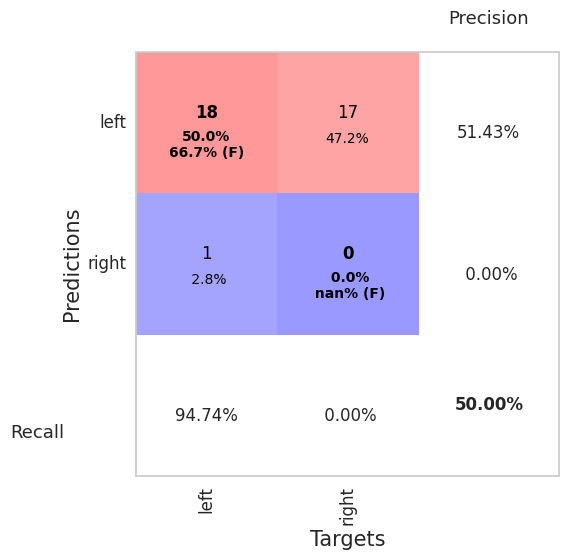

In [6]:

for network in network_list:


    for subject_id in subjects:
        for percent in percent_list:
            run = neptune.init_run(
    project="AitBrainLab/Synthetic",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhMTMyMzg0My02NzlhLTQ3N2ItYTdmMS0yNTcwNDBmM2QwM2QifQ==",
)

            #torch.manual_seed(3407)
            eeg = EEG_fif(path, base_url, subjects, runs)
            raw=eeg.data_to_raw()
            raw=raw.filter( 8,35, method='fir', verbose=20)
            epochs=eeg.epochs_visu(raw,tmin=0,tmax=7,baseline=(0,2))
            X_train, y = eeg.get_X_y(epochs)
            y_train=y-1

            sfreq = 250
            print(sfreq)


            X_syntheic = np.load("Synthetic_data_shift/X_subject_{}.npy")
            y_syntheic = np.load("Synthetic_data_shift/X_subject_{}.npy")
            if len(types_list) == 2:
                for task in types_list :
                    if task == "left":
                        X1 = X_syntheic[np.random.randint(0,72,percent)]
                        y1 = y_syntheic[np.random.randint(0,72,percent)]
                    if task == "right":
                        X2 = X_syntheic[np.random.randint(72,144,percent)]
                        y2 = y_syntheic[np.random.randint(72,144,percent)]
                X_syntheic = np.concatenate((X1,X2),axis=0)
                y_syntheic = np.concatenate((y1,y2),axis=0)
            X_train = np.concatenate((X_train,X_syntheic),axis = 0)
            y_train = np.concatenate((y_train, y_syntheic),axis = 0)




            X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size=0.3,stratify=y_train)

            print('train size',X_train.shape, y_train.shape)
            print('test size',X_test.shape, y_test.shape)

            batch_size = X_train.shape[2]

            train_loader = create_dataloader(X_train, y_train, batch_size=batch_size)
            test_loader = create_dataloader(X_test, y_test, batch_size=batch_size)

            n_classes=2
            n_chans = 8

            #network_list = ['ATCNet', 'ShallowFBCSPNet', 'Deep4Net', 'EEGNetv4']
            if network == 'ATCNet' :
                model = ATCNet(
                                n_chans,
                                n_classes,
                    input_size_s = 7.,

                                )
            if network == "ShallowFBCSPNet":
                model = ShallowFBCSPNet(
                n_chans,
                n_classes,
                input_window_samples=1751,
                final_conv_length="auto",
                )
            if network == "EEGITNet":
                model = EEGITNet(
                    n_classes,
                    n_chans,
                    input_window_samples=1751,
                    )
            if network == "Deep4Net":
                model = Deep4Net(
                    n_chans,
                    n_classes,
                    input_window_samples=1751,
                    final_conv_length='auto',
                    n_filters_time=25,
                    n_filters_spat=25,
                    filter_time_length=10,
                    pool_time_length=3,
                    pool_time_stride=3,
                    n_filters_2=50,
                    filter_length_2=10,
                    n_filters_3=100,
                    filter_length_3=10,
                    n_filters_4=200,
                    filter_length_4=10,
                    first_pool_mode="max",
                    later_pool_mode="max",
                    drop_prob=0.5,
                    #double_time_convs=False,
                    split_first_layer=True,
                    batch_norm=True,
                    batch_norm_alpha=0.1,
                    stride_before_pool=False
                    )



            params = {"Subject number":subject_id,
                      "learning_rate": lr ,
                      "optimizer": "AdamW" ,
                      "Network": network,
                      "Datasets":"S20+Synthetic_data_online",
                      "sfreq":250,
                      "Class number":2,
                      "Channel number": 8,
                      "samples point" : X_train.shape[2]

                      }
            run["parameters"] = params
            net = model.cuda(0)
            optimizer = optim.Adam(net.parameters(), lr=lr)
            criterion = nn.CrossEntropyLoss()#nn.BCELoss()#
            train_loss,valid_loss,train_accuracy,valid_accuracy,part_weights =train(
                                                                        model = net,
                                                                        gpu_num = 0,
                                                                        train_loader = train_loader,
                                                                        test_loader = test_loader,
                                                                        optimizer = optimizer  ,
                                                                        criterion = criterion,
                                                                        num_epochs=n_epochs,
                                                                        save_weights= True,
                                                                        lr=lr
                                                                             )
            model.load_state_dict(torch.load(part_weights))
            eval(model = net,
                gpu_num = 0,
                vail_loader= test_loader,
                 lables = types_list
                 )


            run.stop()